In [2]:
from __future__ import division
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob

### Import data

In [3]:
bias_list = glob.glob('Cosmonauts_GC_data/Bias/*.fits')
dark_list = glob.glob('Cosmonauts_GC_data/Dark/*.fits')
Bflat_list = glob.glob('Cosmonauts_GC_data/Bflat/*.fits')
Vflat_list = glob.glob('Cosmonauts_GC_data/Vflat/*.fits')
B_list = glob.glob('Cosmonauts_GC_data/B/*.fits')
V_list = glob.glob('Cosmonauts_GC_data/V/*.fits')
R_list = glob.glob('Cosmonauts_GC_data/R/*.fits')

### Get a master bias

In [4]:
#Define a zero array
master_bias = np.zeros(fits.getdata(bias_list[0]).shape)

#Get master bias
for i in range(len(bias_list)):
    master_bias += fits.getdata(bias_list[i])

master_bias /= len(bias_list)
m_bias = master_bias[0:1000,0:900]
print(np.average(m_bias))

1148.6806468888885


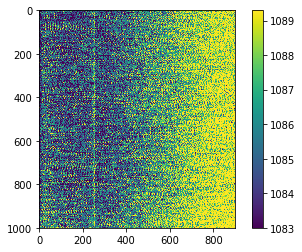

In [5]:
plt.imshow(m_bias,vmin = np.percentile(master_bias,16),vmax = np.percentile(master_bias,84))
plt.colorbar()

### Dark

In [6]:
#Define a zero array
m_dark = np.zeros((m_bias.shape[0],m_bias.shape[1],len(dark_list)))

for i in range(len(dark_list)):
    hdr_d = fits.getdata(dark_list[i])
    hdr_d = hdr_d[0:1000,0:900]
    m_dark[:,:,i] = (hdr_d - m_bias)/30.0
    

m_dark = np.median(m_dark, axis = 2)
print(m_dark)

[[0.49666667 0.46666667 0.48       ... 0.62666667 0.36666667 0.74333333]
 [0.57666667 0.39666667 0.54       ... 0.55666667 0.6        0.62      ]
 [0.68       0.58666667 0.45333333 ... 0.78666667 0.53       0.38      ]
 ...
 [0.34       0.58333333 0.58333333 ... 0.56666667 0.46333333 0.6       ]
 [0.45333333 0.41666667 0.37666667 ... 0.50333333 0.37       0.64666667]
 [0.48333333 0.67       0.26333333 ... 0.58       0.60666667 0.42666667]]


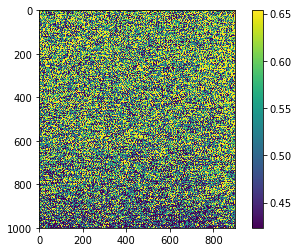

In [7]:
plt.imshow(m_dark,vmin = np.percentile(m_dark,16),vmax = np.percentile(m_dark,84))
plt.colorbar()

### Flats

In [8]:
#Define a zero array for Bflat
m_Bflat = np.zeros((m_bias.shape[0],m_bias.shape[1],len(Bflat_list)))

for i in range(len(Bflat_list)):
    hdr_Bf = fits.getdata(Bflat_list[i])
    hdr_Bf = hdr_Bf[0:1000,0:900]
    m_Bflat[:,:,i] = (hdr_Bf - m_bias)-m_dark*30.
    
    
print(m_Bflat.shape)
m_Bflat = np.median(m_Bflat, axis = 2)
m_Bflat /= np.median(m_Bflat)

(1000, 900, 15)


In [9]:
#Define a zero array for Vflat
m_Vflat = np.zeros((m_bias.shape[0],m_bias.shape[1],len(Vflat_list)))

for i in range(len(Vflat_list)):
    hdr_Vf = fits.getdata(Vflat_list[i])
    hdr_Vf = hdr_Vf[0:1000,0:900]
    m_Vflat[:,:,i] = (hdr_Vf - m_bias)-m_dark*3.
    
m_Vflat = np.median(m_Vflat, axis = 2)
m_Vflat /= np.median(m_Vflat)

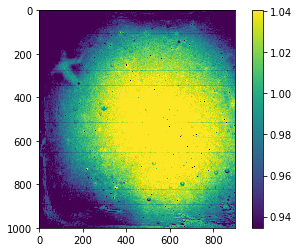

In [10]:
plt.imshow(m_Bflat,vmin = np.percentile(m_Bflat,16),vmax = np.percentile(m_Bflat,84))
plt.colorbar()

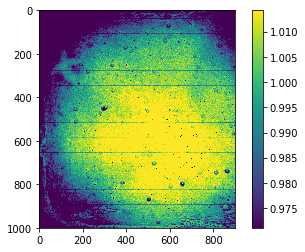

In [11]:
plt.imshow(m_Vflat,vmin = np.percentile(m_Vflat,16),vmax = np.percentile(m_Vflat,84))
plt.colorbar()

### M53_Light Frames

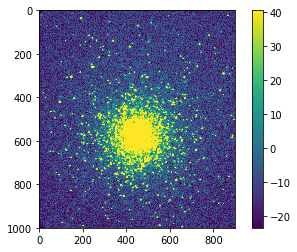

In [12]:
#define a functioon that saves the fits
def write_hdulist_to(hdulist, fileobj, overwrite= True, **kwargs):
    hdulist.writeto(fileobj, overwrite = True, **kwargs)

#Calibrate for every B
m_B = np.zeros((m_bias.shape[0],m_bias.shape[1],len(B_list))) 

for i in range(len(B_list)):
    hdu_B = fits.open(B_list[i],mode='update')
    hdu_Bdata = hdu_B[0].data
    hdu_Bhdr = hdu_B[0].header
    obs_num = hdu_Bhdr['OBSNUM']
    filtname = hdu_Bhdr['FILTNAM']
    filtname = filtname.strip()
    #define names for the files
    uni_ID = str(obs_num)+'_'+filtname
    #chop the images
    hdu_Bdata = hdu_Bdata[0:1000,0:900]
    #do the data reducation
    m_B[:,:,i] = (hdu_Bdata - m_bias)
    m_B[:,:,i] -= m_dark*30.
    w = np.divide(m_B[:,:,i], m_Bflat, out=np.zeros_like(m_B[:,:,i]), where=m_Bflat!=0)
    #save every image
    outhdu = fits.PrimaryHDU(data = w, header = hdu_Bhdr)
    write_hdulist_to(outhdu, './Reduced_M53/red_B/{}.fits'.format(uni_ID))
    
n = 0
plt.imshow(m_B[:,:,n],vmin = np.percentile(m_B[:,:,n],5),vmax = np.percentile(m_B[:,:,n],95))
plt.colorbar()

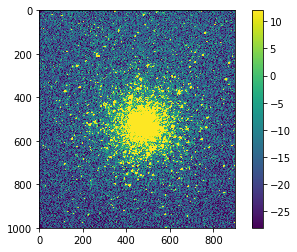

In [13]:
#Calibrate for every V
m_V = np.zeros((m_bias.shape[0],m_bias.shape[1],len(V_list))) 

for i in range(len(V_list)):
    hdu_V = fits.open(V_list[i])
    hdu_Vdata = hdu_V[0].data
    hdu_Vhdr = hdu_V[0].header
    obs_num = hdu_Vhdr['OBSNUM']
    filtname = hdu_Vhdr['FILTNAM']
    filtname = filtname.strip()
    uni_ID = str(obs_num)+'_'+filtname
    hdu_Vdata = hdu_Vdata[0:1000,0:900]
    m_V[:,:,i] = (hdu_Vdata - m_bias)
    m_V[:,:,i] -= m_dark*30.
    b = np.divide(m_V[:,:,i], m_Vflat, out=np.zeros_like(m_V[:,:,i]), where=m_Vflat!=0)
    outhdu = fits.PrimaryHDU(data = b, header = hdu_Vhdr)
    write_hdulist_to(outhdu, './Reduced_M53/red_V/{}.fits'.format(uni_ID))

#How a reduced single frame look like
a = 9
plt.imshow(m_V[:,:,a],vmin = np.percentile(m_V[:,:,a],5),vmax = np.percentile(m_V[:,:,a],95))
plt.colorbar()

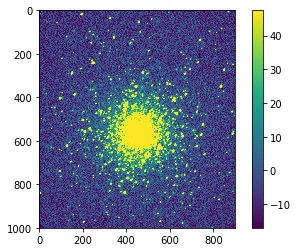

In [14]:
#Calibrate for every R for fun
m_R = np.zeros((m_bias.shape[0],m_bias.shape[1],len(R_list))) 

for i in range(len(R_list)):
    hdu_R = fits.open(R_list[i])
    hdu_Rdata = hdu_R[0].data
    hdu_Rhdr = hdu_R[0].header
    obs_num = hdu_Rhdr['OBSNUM']
    filtname = hdu_Rhdr['FILTNAM']
    filtname = filtname.strip()
    uni_ID = str(obs_num)+'_'+filtname
    hdu_Rdata = hdu_Rdata[0:1000,0:900]
    m_R[:,:,i] = (hdu_Rdata - m_bias)
    m_R[:,:,i] -= m_dark*30.
    r = np.divide(m_R[:,:,i], m_Vflat, out=np.zeros_like(m_R[:,:,i]), where=m_Vflat!=0)
    outhdu = fits.PrimaryHDU(data = r, header = hdu_Rhdr)
    write_hdulist_to(outhdu, './Reduced_M53/red_R/{}.fits'.format(uni_ID))

#How a reduced single frame look like
a = 0
plt.imshow(m_V[:,:,a],vmin = np.percentile(m_V[:,:,a],5),vmax = np.percentile(m_V[:,:,a],95))
plt.colorbar()

### Making an RGBimage

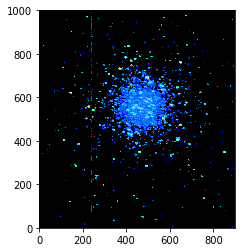

In [15]:
from astropy.visualization import make_lupton_rgb #the module that makes rgb image

b = fits.getdata('Reduced_M53/alignedRGB/aligned_M53_reduced_B.fits',ignore_missing_end=True)
g = fits.getdata('Reduced_M53/alignedRGB/aligned_M53_reduced_V.fits',ignore_missing_end=True)
r = fits.getdata('Reduced_M53/alignedRGB/aligned_M53_reduced_R.fits',ignore_missing_end=True)

#use make_lupton_rbg to get a rgb image
#stretch and Q will change how the values between black and white are scaled
#save as a png file
rgb_default = make_lupton_rgb(r, g, b, Q=10,stretch=0.08,filename = "M53_RGB.png")

#show the stacked image
plt.imshow(rgb_default, vmin=5, vmax=95, origin='low')

### Standard_Star

In [16]:
#Calibrate for B standard star
SS_B = np.zeros((m_bias.shape[0],m_bias.shape[1]))

hdu_B = fits.open('Standard_Star/d103.fits')
hdu_Bdata = hdu_B[0].data
hdu_Bhdr = hdu_B[0].header
filtname = hdu_Bhdr['FILTNAM']
filtname = filtname.strip()
uni_ID = 'ss' + '_'+filtname
hdu_Bdata = hdu_Bdata[0:1000,0:900]
SS_B[:,:] = (hdu_Bdata - m_bias)
SS_B[:,:] -= m_dark*15.
ssb = np.divide(SS_B[:,:], m_Bflat, out=np.zeros_like(SS_B[:,:]), where=m_Bflat!=0)
outhdu = fits.PrimaryHDU(data = ssb, header = hdu_Bhdr)
write_hdulist_to(outhdu, '{}.fits'.format(uni_ID))

In [17]:
#Calibrate for V standard star
SS_V = np.zeros((m_bias.shape[0],m_bias.shape[1]))

hdu_V = fits.open('Standard_Star/d104.fits')
hdu_Vdata = hdu_V[0].data
hdu_Vhdr = hdu_V[0].header
filtname = hdu_Vhdr['FILTNAM']
filtname = filtname.strip()
uni_ID = 'ss' + '_'+filtname
hdu_Vdata = hdu_Vdata[0:1000,0:900]
SS_V[:,:] = (hdu_Vdata - m_bias)
SS_V[:,:] -= m_dark*15.
ssv = np.divide(SS_V[:,:], m_Vflat, out=np.zeros_like(SS_V[:,:]), where=m_Vflat!=0)
vouthdu = fits.PrimaryHDU(data = ssv, header = hdu_Vhdr)
write_hdulist_to(vouthdu, '{}.fits'.format(uni_ID))

### Handle the extracted data

In [18]:
#read the data
B_data = np.loadtxt('M53_extracted/B_M53.dat')
V_data = np.loadtxt('M53_extracted/V_M53.dat')
ss_V = np.loadtxt('M53_extracted/red_stdStarsV/V_extract.dat')
ss_B = np.loadtxt('M53_extracted/red_stdStarsB/B_extract.dat')
isochrone = np.loadtxt('M53_extracted/isochrone.dat')

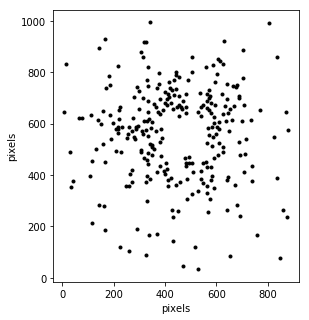

In [19]:
#plot the location of the stars
flagB = B_data[:, 5]
insmagB = B_data[:,3]
insmagV = V_data[:,3]
useflag = (flagB == 0)
usemagB = (insmagB < 99.)
usemagV = (insmagV < 99.)

plt.figure(figsize=(5,5))
plt.scatter(B_data[useflag & usemagB,1],B_data[useflag & usemagB,2],marker=".",c='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.savefig('M53_Scatter.png')

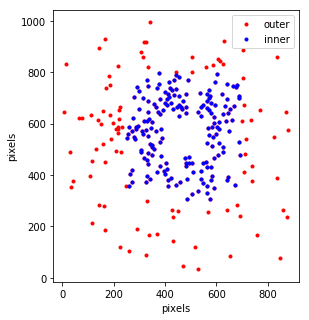

In [22]:
#Plot the location of the stars, inner and outer
x_cord = B_data[:,1]
y_cord = B_data[:,2]
xmask_in = ((250.<x_cord)&(x_cord<700.))
ymask_in = ((300.<y_cord)&(y_cord<800.))
xmask_out = np.logical_or(x_cord <= 250., x_cord >= 700.)
ymask_out = np.logical_or(x_cord <= 300., x_cord >= 800.)

plt.figure(figsize=(5,5))

plt.scatter(V_data[useflag & usemagB,1],V_data[useflag & usemagB,2],marker=".",c='red',label="outer")
plt.scatter(V_data[useflag & usemagB & ymask_in & xmask_in,1],V_data[useflag & usemagB  & ymask_in & xmask_in ,2],marker=".",c='blue',label="inner")

plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.savefig('seperate_scatter.png')

In [21]:
# find magnitude zeropoint for standard star
ssV_ins = ss_V[1,5]
ssB_ins = ss_B[1,5]
VVega = 10.37
BVVega = -0.166
ssV_mag = VVega+0.02
ssB_mag = VVega+BVVega -0.09
mzp_V = ssV_mag - ssV_ins
mzp_B = ssB_mag - ssB_ins
print(mzp_V)
print(mzp_B)

25.35
25.003999999999998


272


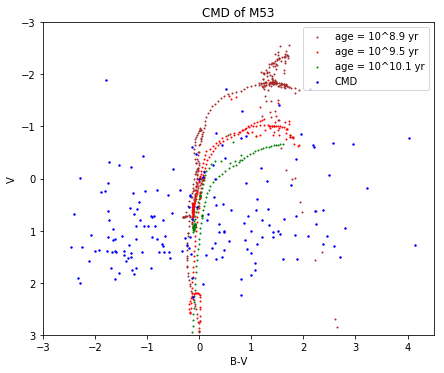

In [26]:
# plot B-V versus V
#use flags==0 and exclude ins_mag 99. 

flagB = B_data[:, 5]
insmagB = B_data[:,3]
insmagV = V_data[:,3]
age = isochrone[:,1]

useflag = (flagB == 0)
usemagB = (insmagB < 99.)
usemagV = (insmagV < 99.)
xmask_in = ((250.<x_cord)&(x_cord<700.))
ymask_in = ((300.<y_cord)&(y_cord<800.))
xmask_out = np.logical_or(x_cord <= 250., x_cord >= 700.)
ymask_out = np.logical_or(x_cord <= 300., x_cord >= 800.)


#definde instrmental magnitudes for B and V band
V_ins = V_data[useflag & usemagB,3]
B_ins = B_data[useflag & usemagB,3]

#get the ab magnitude of inner part M53, also apply DM and extension
V_ins_in = V_data[useflag & usemagB & xmask_in & ymask_in,3]
B_ins_in = B_data[useflag & usemagB & xmask_in & ymask_in,3]
Vab_in = V_ins_in + mzp_V - 16.32 -0.077
Bab_in = B_ins_in + mzp_B - 16.32 -0.025


#get the ab magnitude of isochrone
age = isochrone[:,1]
def useage(x):
    return (age==x)

#B_iso = isochrone[useage,24]
#V_iso = isochrone[useage,25]

#Vab = V_ins + mzp_V -0.077 -16.32
#Bab = B_ins + mzp_B -0.025 -16.32
#V_iso = isochrone[useage,26]
#B_iso = isochrone[useage,25]
#BVab = Bab-Vab
#plt.scatter(BVab,Vab,s=3,c='black')

#plot
plt.figure(figsize=(7,7))

plt.scatter(isochrone[useage(8.9),24]-isochrone[useage(8.9),25],isochrone[useage(8.9),25],s=1,c='brown',label="age = 10^8.9 yr")
plt.scatter(isochrone[useage(9.5),24]-isochrone[useage(9.5),25],isochrone[useage(9.5),25],s=1,c='red',label="age = 10^9.5 yr")
plt.scatter(isochrone[useage(10.1),24]-isochrone[useage(10.1),25],isochrone[useage(10.1),25],s=1,c='green',label="age = 10^10.1 yr")
plt.scatter(Bab_in-Vab_in,Vab_in,s=2,c='blue',label="CMD")

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-3,4.5)
plt.ylim(3,-3)
plt.xlabel('B-V')
plt.ylabel('V')
plt.title('CMD of M53')
plt.legend()
plt.savefig('M53-CMD.png')
print(V_ins.size)

### Split the inner and outter part of cluster

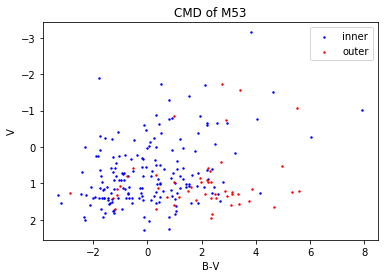

In [519]:
V_ins_in = V_data[useflag & usemagB & xmask_in & ymask_in,3]
B_ins_in = B_data[useflag & usemagB & xmask_in & ymask_in,3]
Vab_in = V_ins_in + mzp_V - 16.32 -0.077
Bab_in = B_ins_in + mzp_B - 16.32 -0.025

V_ins_out = V_data[useflag & usemagB & xmask_out & ymask_out,3]
B_ins_out = B_data[useflag & usemagB & xmask_out & ymask_out,3]
Vab_out = V_ins_out + mzp_V - 16.32 -0.077
Bab_out = B_ins_out + mzp_B - 16.32 -0.025

plt.scatter((Bab_in-Vab_in),Vab_in,s=2,c='blue',label="inner")
plt.scatter((Bab_out-Vab_out),Vab_out,s=2,c='red',label="outer")

plt.xlabel('B-V')
plt.ylabel('V')
plt.title('CMD of M53')
plt.legend()
plt.gca().invert_yaxis()

plt.savefig('M53-CMD-split.png')

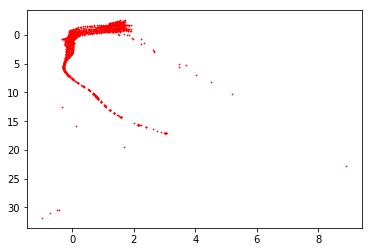

In [471]:
plt.scatter(B_iso-V_iso,V_iso,s=0.5,c='red',label="isochrones")
plt.gca().invert_yaxis()